In [41]:
#!pip install git+https://github.com/tensorflow/examples.git
#!pip install git+https://github.com/surmenok/keras_lr_finder

In [42]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import os
#import albumentations as A
from tensorflow_examples.models.pix2pix import pix2pix
from keras_lr_finder import LRFinder
from tensorflow import keras
from tqdm import tqdm

In [43]:
train_text_file = "VOCtrainval_11-May-2012/VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt"
val_text_file = "VOCtrainval_11-May-2012/VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt"
image_folder = "VOCtrainval_11-May-2012/VOCdevkit/VOC2012/JPEGImages"
mask_folder = "VOCtrainval_11-May-2012/VOCdevkit/VOC2012/SegmentationClass"

image_size = (128, 128)

In [44]:
def read_paths_img_masks(text_file_path, image_path, mask_path):
    paths = []
    with open(text_file_path, "r") as file:
        file_names = file.readlines()
    for file_name in tqdm(file_names):
        image = os.path.join(image_path, file_name.strip() + ".jpg")
        mask = os.path.join(mask_path, file_name.strip() + ".png")
        paths.append((image, mask))
    return paths


In [45]:
train_paths = read_paths_img_masks(train_text_file, image_folder, mask_folder)
val_paths = read_paths_img_masks(val_text_file, image_folder, mask_folder)

100%|██████████| 1449/1449 [00:00<00:00, 231252.48it/s]


In [46]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask[input_mask == 255] = 21
    input_mask = input_mask[ ..., np.newaxis]
    input_mask = input_mask[:, :, 0]
    return input_image, input_mask

In [47]:
def load_image_and_resize(file_path):
    img = Image.open(file_path)
    img = img.resize(image_size)
    return np.array(img)

In [48]:
def load_image_and_mask(paths_tuple):
    input_image = load_image_and_resize(paths_tuple[0])
    input_mask = load_image_and_resize(paths_tuple[1])
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask


In [49]:
def load_dataset(paths):
    imgs = []
    masks = []
    for path in tqdm(paths):
        #print("Processing: ", path)
        img, mask = load_image_and_mask(path)
        imgs.append(img)
        masks.append(mask)
    return np.array(imgs), np.array(masks)

In [51]:
print("Loading Training Dataset...")
train_dataset = tf.data.Dataset.from_tensor_slices(load_dataset(train_paths))
print("Loading Validation Dataset...")
validation_set = tf.data.Dataset.from_tensor_slices(load_dataset(val_paths))

Loading Training Dataset...


100%|██████████| 1464/1464 [00:13<00:00, 111.08it/s]


Loading Validation Dataset...


100%|██████████| 1449/1449 [00:13<00:00, 111.01it/s]


In [54]:
full_dataset = validation_set.shuffle(buffer_size = len(validation_set))
test_dataset = validation_set.take(len(validation_set)//2)
val_dataset = validation_set.skip(len(test_dataset))


In [9]:
def load_images(path):
    temp = []
    updated_path = os.path.join(path,"VOC2012","ImageSets","Segmentation","trainval.txt")
    with open(updated_path,"r") as file_:
        Instances = file_.read().split()
        img_arr = []
        seg_arr = []
        for img in tqdm(Instances):
            path_img = os.path.join(path,"VOC2012","JPEGImages",img+".jpg")
            path_seg = os.path.join(path,"VOC2012","SegmentationClass",img+".png")
            img = np.array(Image.open(path_img).resize((IMG_WIDTH, IMG_HEIGHT)))
            seg = np.array(Image.open(path_seg).resize((IMG_WIDTH, IMG_HEIGHT)))
            seg[seg == 255] = 21
            img_arr.append(img)
            seg_arr.append(seg)
    return np.array(img_arr), np.array(seg_arr)

In [10]:
path = "VOCtrainval_11-May-2012/VOCdevkit"
full_dataset = tf.data.Dataset.from_tensor_slices(Read_All_Data(path))


100%|██████████| 2913/2913 [00:23<00:00, 121.52it/s]
2021-10-02 11:16:29.548870: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
DATASET_SIZE = len(full_dataset)


In [17]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.2 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

full_dataset = full_dataset.shuffle(buffer_size = DATASET_SIZE)
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

In [ ]:
# def Read_Data(path,is_train = True):
#     temp = []
#     updated_path = os.path.join(path,"VOC2012","ImageSets","Segmentation","train.txt" if is_train else "val.txt")
#     with open(updated_path,"r") as file_:
#         Instances = file_.read().split()
#         img_arr = []
#         seg_arr = []
#         for img in Instances:
#             path_img = os.path.join(path,"VOC2012","JPEGImages",img+".jpg")
#             path_seg = os.path.join(path,"VOC2012","SegmentationClass",img+".png")
#             img = np.array(Image.open(path_img).resize((IMG_WIDTH, IMG_HEIGHT)))
#             seg = np.array(Image.open(path_seg).resize((IMG_WIDTH, IMG_HEIGHT)))
#             seg[seg == 255] = 21
#             img_arr.append(img)
#             seg_arr.append(seg)
#     return np.array(img_arr), np.array(seg_arr)

In [ ]:
# path = "../input/pascal-voc-2012"
# train_data = Read_Data(path, is_train = True)
# val_data   = Read_Data(path, is_train = False)

In [ ]:
# TRAIN_LENGTH = train_data[0].shape[0]
# TEST_LENGTH = val_data[0].shape[0]

In [18]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

In [ ]:
# train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
# test_dataset = tf.data.Dataset.from_tensor_slices(val_data)

### We need some agumentation while loading the training set in order to prevent overfitting 

In [19]:
def load_image_train(input_image, input_mask):
    input_mask = input_mask[ ..., np.newaxis]
    

    # random flip the image and mask
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    
    input_mask = input_mask[:, :, 0]
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [55]:
def load_image_test(input_image, input_mask):
    input_mask = input_mask[np.newaxis, ...]
    
    
    input_mask = input_mask[0]
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [56]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = train_size // BATCH_SIZE

In [57]:
train = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val   = train_dataset.map(load_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test_dataset.map(load_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)

TypeError: in user code:

    /var/folders/t3/t_6hg0q576vbv5hbdh1zdckw0000gn/T/ipykernel_6127/1214705259.py:11 load_image_train  *
        input_image, input_mask = normalize(input_image, input_mask)
    /var/folders/t3/t_6hg0q576vbv5hbdh1zdckw0000gn/T/ipykernel_6127/3829336884.py:3 normalize  *
        input_mask[input_mask == 255] = 21

    TypeError: 'Tensor' object does not support item assignment


In [23]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)
val_dataset = val.batch(BATCH_SIZE)

### show an example of image and mask

In [26]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(np.array(display_list[i]))
        plt.axis('off')
    plt.show()

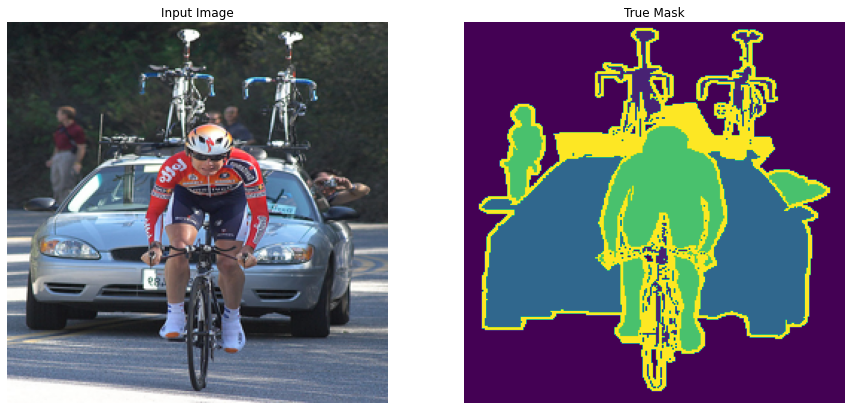

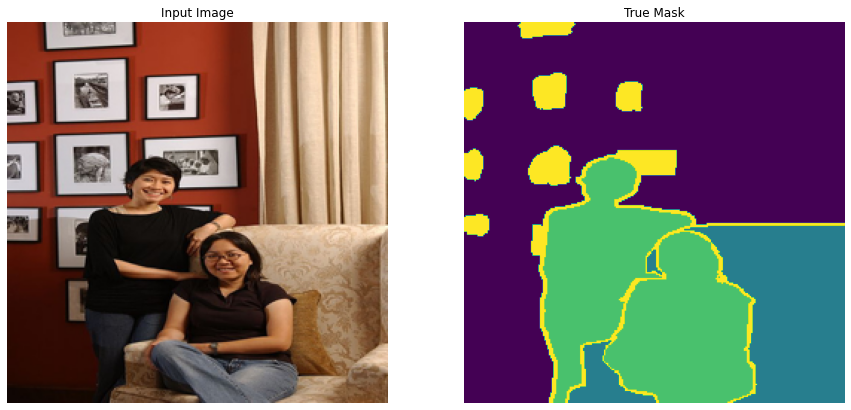

In [27]:
for image, mask in train.take(2):
    sample_image, sample_mask = image, mask
    display([sample_image, sample_mask])

In [28]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[IMG_HEIGHT, IMG_WIDTH, 3], include_top=False)

# use the output of listed layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# build the feature extraction model (encoder)
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
# we'll not change the parameter of the decoder
down_stack.trainable = False

9420800/9406464 [==============================] - 1s 0us/step


In [29]:
# build the upsampling model (decoder)
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [30]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    x = inputs

    # downsampling and extract features 
    skips = down_stack(x)
    x = skips[-1]
    # layers to establish skip connections in the encoder model
    skips = reversed(skips[:-1])

    # establish skip connections between layers of encoder and decoder
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # the last layer 
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

### find the optimal learning rate

In [31]:
OUTPUT_CHANNELS = 22
model = unet_model(OUTPUT_CHANNELS)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# x, y = next(iter(val_dataset))

# for x_, y_ in val_dataset:
#     x = tf.concat((x, x_), axis=0)
#     y = tf.concat((y, y_), axis=0)
    
# # use lr_finder to draw the cycling learning rate
# lr_finder = LRFinder(model)
# lr_finder.find(x, y, start_lr=1e-10, end_lr=1, batch_size=32, epochs=10)
# lr_finder.plot_loss()

### From the above figure, 1e-4 is the optimal learning rate

In [32]:
optimizer = keras.optimizers.Adam(lr=1e-4)

/Users/sanjay/Applications/anaconda3/anaconda3/envs/tf/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [33]:
OUTPUT_CHANNELS = 22
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
tf.keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [35]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [36]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [37]:
EPOCHS = 30
VAL_SUBSPLITS = 5
VALIDATION_STEPS = val_size//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_dataset)

Epoch 1/30
12/63 [====>.........................] - ETA: 3:39 - loss: 3.3002 - accuracy: 0.0979

KeyboardInterrupt: 

In [ ]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(np.array(display_list[i]))
        plt.axis('off')
    plt.show()

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
show_predictions(train_dataset, num =10)

In [ ]:
show_predictions(test_dataset.shuffle(buffer_size=64), num =10)

In [ ]:
show_predictions(val_dataset.shuffle(buffer_size=64), num =10)

In [ ]:
model.evaluate(test_dataset)

### Model inference and extract mask

In [ ]:
!mkdir source
!mkdir mask

In [ ]:
cnt = 0
for image, mask in train_dataset.take(10):
    pred_mask = model.predict(image)
    pred_mask = create_mask(pred_mask)
    pred_mask = (np.array(pred_mask) !=0).astype(int)
#     print(image[0].shape)
#     print(pred_mask.shape)
    Image.fromarray((np.array(image[0]*255).astype(np.uint8))).save(f"source/source_{cnt}.jpg")
    Image.fromarray((pred_mask[:,:,0]*255).astype(np.uint8)).save(f"mask/mask_{cnt}.jpg")
    display([image[0], pred_mask[:, :, 0], image[0] * pred_mask])
    cnt += 1

In [ ]:
# cat_img = np.array(Image.open("../input/pascal-voc-2012/VOC2012/JPEGImages/2007_000241.jpg").resize((256, 256)))
# pred_mask = model.predict(cat_img[np.newaxis,...])
# mask = create_mask(pred_mask)
# mask = np.array(mask!=0, dtype=int)